In [1]:
using HDF5
using Plots
using LadderDGA
using Suppressor
using Logging

#path_to_input = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s0_b12_u1.0"
#path_to_output = "$(@__DIR__)/../../lDGA_test_runs"
cfg_file = "$(@__DIR__)/../../lDGA_test_runs/config.toml"
cfg_file2 = "$(@__DIR__)/../../lDGA_test_runs/config2.toml"

empty!(ARGS);
#push!(ARGS,path_to_input);
#push!(ARGS,path_to_output);
#include("../scripts/triqs_conv.jl");

io = stdout
metafmt(level::Logging.LogLevel, _module, group, id, file, line) = Logging.default_metafmt(level, nothing, group,     id, nothing, nothing)
logger = ConsoleLogger(io, Logging.Info, meta_formatter=metafmt, show_limited=true, right_justify=0)
global_logger(logger);

┌ Info: Precompiling LadderDGA [78e40beb-bf89-4c0e-9d2b-bee278912f2b]
└ @ Base loading.jl:1317


Loading impurity quantities and constructing k grids.
removing the @supress block activates debugging output.

In [2]:
mP, sP, env, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
kG = kGrids[1]
qG = qGrids[1]
νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);

mP2, sP2, env2, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file2)
νGrid2, sumHelper_f2, impQ_sp2, impQ_ch2, GImp_fft2, GLoc_fft2, Σ_loc2, FUpDo2, gImp2, gLoc2 = setup_LDGA(kG, freqList, mP2, sP2, env2);

[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
[ Info: Computing kinetic energie for improved bosonic sums.
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities iwth ranges are:
│ χLoc_sp(16:26) = 0.2694, χLoc_ch(16:26) = 0.093 
└ sum χupup check (normal/improved sum, tail sub sum, expected): 0.1811947008638526 ?≈? 0.21805433867068705 ?≈? 0.25"
[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
[ Info: Computing kinetic energie for improved bosonic sums.
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities iwth ranges are:
│ χLoc_sp(16:26) = 0.2696, χLoc_ch(16:26) = 0.0932 
└ sum χupup check (normal/improved sum, tail sub sum, expected): 0.1813620894231569 ?≈? 0.21822172722999142 ?≈? 0.25"


# Lambda charge solutions investigation

In [3]:
# "local" correction quantities
bubbleLoc = calc_bubble(νGrid, GImp_fft, qGridLoc, mP, sP);
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, -mP.U, mP, sP);
Σ_ladderLoc = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, GImp_fft, FUpDo,
                     qGridLoc, sumHelper_f, mP, sP)
Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;

In [4]:
# non local quantities 
bubble = calc_bubble(νGrid, GLoc_fft, qG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, qG, νGrid, sumHelper_f, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, qG, νGrid, sumHelper_f, -mP.U, mP, sP);

In [5]:
# non local quantities 
bubble2 = calc_bubble(νGrid, GLoc_fft2, qG, mP2, sP2);
nlQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubble2, qG, νGrid, sumHelper_f2, mP2.U, mP2, sP2);
nlQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubble2, qG, νGrid, sumHelper_f2, -mP2.U, mP2, sP2);

In [7]:
sh_1 = LadderDGA.get_sum_helper(nlQ_sp.usable_ω, sP, :b)
sh_12 = LadderDGA.get_sum_helper(nlQ_sp2.usable_ω, sP2, :b)
χspw = LadderDGA.sum_freq(LadderDGA.kintegrate(qG, nlQ_sp.χ[nlQ_sp.usable_ω,:], dim=2)[:,1], [1], sh_1, mP.β)[1]
χspw2 = LadderDGA.sum_freq(LadderDGA.kintegrate(qG, nlQ_sp2.χ[nlQ_sp2.usable_ω,:], dim=2)[:,1], [1], sh_1, mP2.β)[1]

#plot(nlQ_sp.usable_ω, real(impQ_sp.χ_ω[impQ_sp.usable_ω]))
#plot!(nlQ_sp2.usable_ω, real(impQ_sp2.χ_ω[impQ_sp2.usable_ω]))

0.32781753487133564 + 3.2408353554056115e-10im

In [8]:
println("$χspw vs $χspw2")

0.2823154879418364 + 3.232691029215959e-10im vs 0.32781753487133564 + 3.2408353554056115e-10im


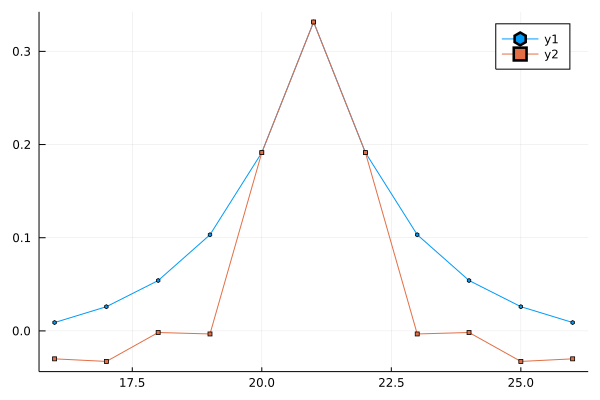

In [15]:
kintegrate = LadderDGA.kintegrate
sum_freq = LadderDGA.sum_freq
χ_λ(χ::AbstractArray, λ::Union{Float64}) = map(χi -> 1.0 / ((1.0 / χi) + λ), χ)
kGrid = qG
β = mP.β

sh = get_sum_helper(nlQ_ch.usable_ω, sP, :b)
χch_ω = kintegrate(kGrid, nlQ_ch.χ, dim=2)[:,1]
χch_sum = real(sum_freq(χch_ω[nlQ_ch.usable_ω], [1], sh, mP.β)[1])
χsp_ω = kintegrate(kGrid, nlQ_sp.χ, dim=2)[:,1]
χsp_sum = real(sum_freq(χsp_ω[nlQ_sp.usable_ω], [1], sh, mP.β)[1])
usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)

sh_2 = get_sum_helper(nlQ_ch2.usable_ω, sP2, :b)
χch_ω_2 = kintegrate(kGrid, nlQ_ch2.χ, dim=2)[:,1]
χch_sum_2 = real(sum_freq(χch_ω_2[nlQ_ch2.usable_ω], [1], sh_2, mP2.β)[1])
χsp_ω_2 = kintegrate(kGrid, nlQ_sp2.χ, dim=2)[:,1]
χsp_sum_2 = real(sum_freq(χsp_ω_2[nlQ_sp2.usable_ω], [1], sh_2, mP2.β)[1])
usable_ω_2 = intersect(nlQ_sp2.usable_ω, nlQ_ch2.usable_ω)

plot(nlQ_ch.usable_ω, real(χch_ω[nlQ_ch.usable_ω]),markershape = :hexagon,markersize = 2)
plot!(nlQ_ch.usable_ω, real(χch_ω_2[nlQ_ch.usable_ω]),markershape = :square,markersize = 2)

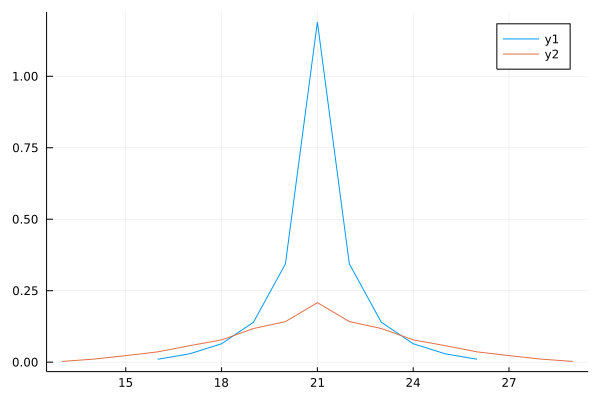

In [16]:
plot(nlQ_sp.usable_ω, real(χsp_ω[nlQ_sp.usable_ω]))
plot!(nlQ_sp2.usable_ω, real(χsp_ω_2[nlQ_sp2.usable_ω]))

In [17]:
λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, qG, mP, sP)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(16:26,16:26) = 16:26 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 16:26, length: 11
│ ch: 16:26, length: 11
│ usable: 16:26, length: 11
└ χch sum = 0.12842719663776692, rhs = 0.23396220508993826
┌ Info: found 
│   χ_min = -0.43150273373528475
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.43150273373528475, 2.235163932931382]"
┌ Info: Method 2 root:
└   r2 = Float64[]
┌ Info: Found λsp 
└   λsp_old = -1.1963027478898748e-16
[ Info: new lambda correction: λsp=0.0 and λch=0.0


(-1.1963027478898748e-16, [0.0, 0.0], [-0.43150273373528475, 2.235163932931382], [-Inf, Inf])

In [18]:
λ_sp2, λ_spch2  = λ_correction!(impQ_sp2, impQ_ch2, FUpDo2, Σ_loc2, Σ_ladderLoc, nlQ_sp2, nlQ_ch2, bubble2, GLoc_fft2, qG, mP2, sP2)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(13:29,20:22) = 20:22 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 13:29, length: 17
│ ch: 20:22, length: 3
│ usable: 20:22, length: 3
└ χch sum = 0.1906267092572944, rhs = 0.1720974695890194
┌ Info: found 
│   χ_min = -4.377901482942061
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-4.377901482942061, -1.7112348162753943]"
┌ Info: Method 2 root:
│   r2 =
│    1-element Vector{Float64}:
└     0.0
┌ Info: Found λsp 
└   λsp_old = -8.436242980773694e-16
[ Info: new lambda correction: λsp=0.0 and λch=0.0


(-8.436242980773694e-16, [0.0, 0.0], [-4.377901482942061, -1.7112348162753943], [-Inf, Inf])

In [19]:
using Roots




sh = get_sum_helper(nlQ_ch.usable_ω, sP, :b)
χch_ω = kintegrate(kGrid, nlQ_ch.χ, dim=2)[:,1]
χch_sum = real(sum_freq(χch_ω[nlQ_ch.usable_ω], [1], sh, mP.β)[1])
rhs1 = mP.n * (1 - mP.n/2) - χch_sum
rhs2 = real(impQ_ch.χ_loc + impQ_sp.χ_loc - χch_sum)
usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω)
sh = get_sum_helper(usable_ω, sP, :b)
χupup_sum = sum_freq(kintegrate(kGrid, 0.5 .* (nlQ_ch.χ[usable_ω,:] .+ nlQ_sp.χ[usable_ω,:]), dim=2)[:,1], [1], sh, mP.β)[1]


sh_2 = get_sum_helper(nlQ_ch2.usable_ω, sP2, :b)
χch_ω_2 = kintegrate(kGrid, nlQ_ch2.χ, dim=2)[:,1]
χch_sum_2 = real(sum_freq(χch_ω_2[nlQ_ch2.usable_ω], [1], sh_2, mP2.β)[1])
rhs1_2 = mP.n * (1 - mP.n/2) - χch_sum_2
rhs2_2 = real(impQ_ch2.χ_loc + impQ_sp2.χ_loc - χch_sum_2)
usable_ω_2 = intersect(nlQ_sp2.usable_ω, nlQ_ch2.usable_ω)
sh_2 = get_sum_helper(usable_ω_2, sP2, :b)
χupup_sum_2 = sum_freq(kintegrate(kGrid, 0.5 .* (nlQ_ch2.χ[usable_ω_2,:] .+ nlQ_sp2.χ[usable_ω_2,:]), dim=2)[:,1], [1], sh_2, mP2.β)[1]

println("usable range: $usable_ω vs $usable_ω_2\nχupup_nc=$χupup_sum\nχupup_rc=$χupup_sum_2")

χ_in = nlQ_sp.χ
usable_ω_i = nlQ_sp.usable_ω
χr    = real.(χ_in[usable_ω_i,:])
sh = get_sum_helper(usable_ω_i, sP, :b)
f(λint) = sum_freq(kintegrate(kGrid, χ_λ(χr, λint), dim=2)[:,1], [1], sh, β)[1] - rhs2
df(λint) = sum_freq(kintegrate(kGrid, -χ_λ(χr, λint) .^ 2, dim=2)[:,1], [1], sh, β)[1]
r2 = find_zeros(f, 0.02, 20.0, verbose=true)

χ_in = nlQ_sp2.χ
usable_ω_i = nlQ_sp2.usable_ω
χr    = real.(χ_in[usable_ω_i,:])
sh = get_sum_helper(usable_ω_i, sP2, :b)
f(λint) = sum_freq(kintegrate(kGrid, χ_λ(χr, λint), dim=2)[:,1], [1], sh, β)[1] - rhs1
df(λint) = sum_freq(kintegrate(kGrid, -χ_λ(χr, λint) .^ 2, dim=2)[:,1], [1], sh, β)[1]
r22 = find_zeros(f, 0.02, 20.0, verbose=true)

println("lambda $r2 vs $r22")

usable range: 16:26 vs 20:22
χupup_nc=0.1443350630570379 - 4.55570753200474e-10im
χupup_rc=0.050258799072102324 - 4.926489644739294e-10im
lambda Float64[] vs Float64[]


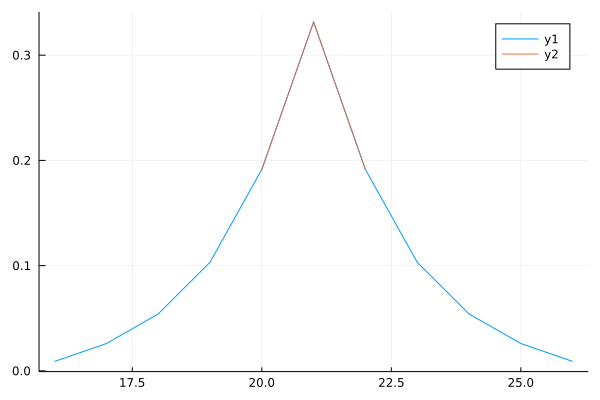

In [20]:
plot(usable_ω, real(χch_ω[usable_ω]))
plot!(usable_ω_2, real(χch_ω_2[usable_ω_2]))